The dataset used for this project is [Optimized Adult Census Income](https://huggingface.co/datasets/Databoost/optimized_adult_census) found on huggingface.com

The two algorithms used to analyze this dataset are logistic regression and a neural network

In [1]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from seaborn import pairplot
from typing import Tuple
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, ConfusionMatrixDisplay



In [2]:
#Load and clean data

df = pd.read_csv('optimized_adult_census.csv')
df.replace('?', pd.NA, inplace=True)
for col in ['workclass','occupation','native.country']:
    df[col] = df[col].fillna('Unknown')

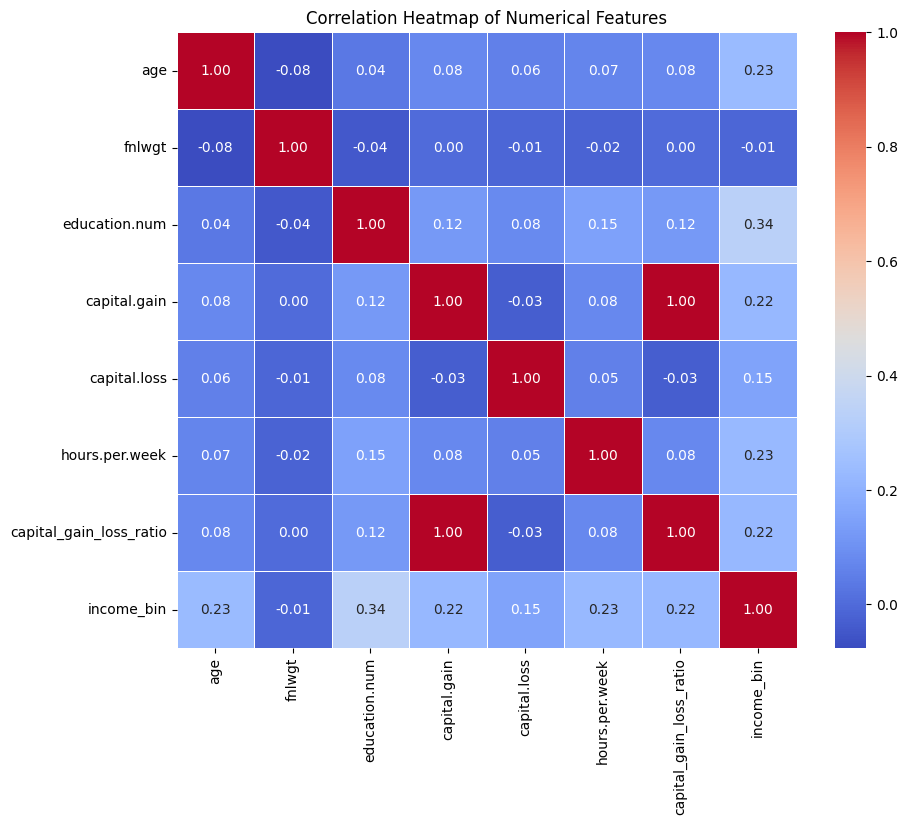

In [9]:
#Heatmap
df['income_bin'] = (df['income'].str.strip() == '>50K').astype(int)
numeric_columns = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'capital_gain_loss_ratio']

numeric_columns.append('income_bin')

corr_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)

plt.title('Correlation Heatmap of Numerical Features')
plt.show()

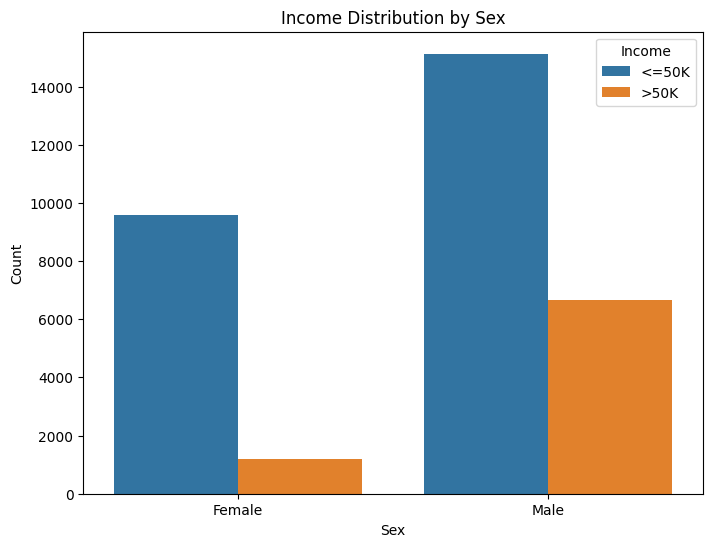

In [4]:
#Bar Graph
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='sex', hue='income')

plt.title('Income Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Income', loc='upper right')

plt.show()

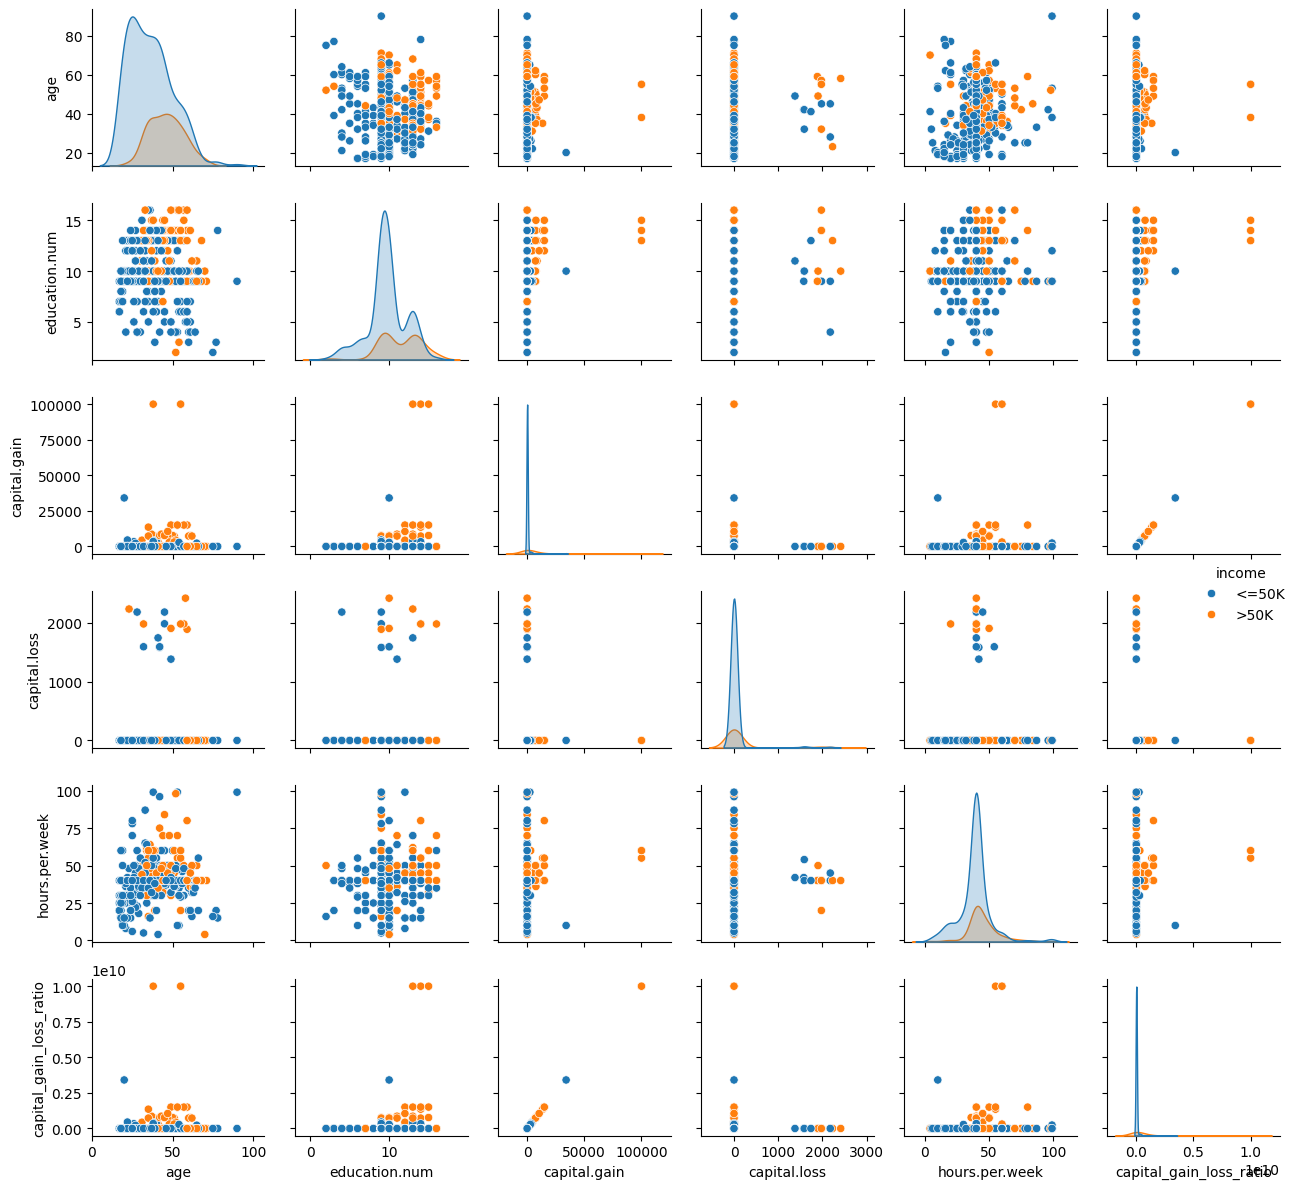

In [5]:
#Pairplot

numeric_cols = [
    'age',
    'education.num',
    'capital.gain',
    'capital.loss',
    'hours.per.week',
    'capital_gain_loss_ratio'
]
plot_cols = numeric_cols + ['income']

sample_df = df[plot_cols].sample(n=500, random_state=42)

sns.pairplot(
    data=sample_df,
    hue='income',
    vars=numeric_cols,
    height=2
)

plt.tight_layout()
plt.show()

Training accuracy:   0.858
Validation accuracy: 0.855
Test accuracy:       0.852


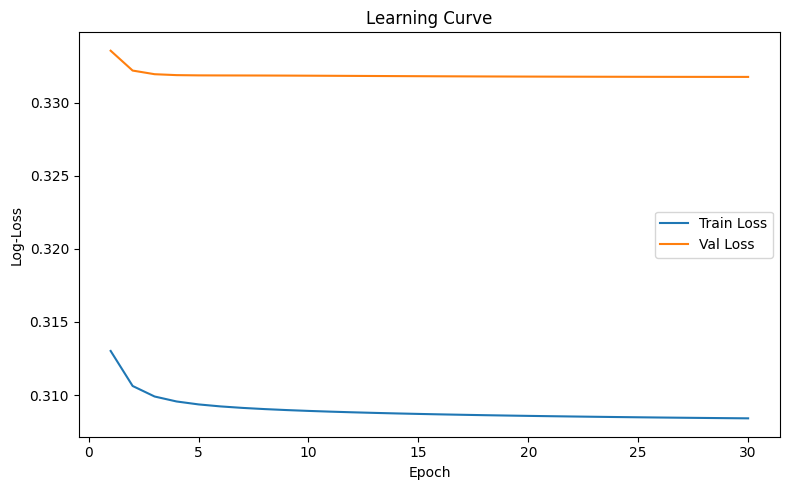

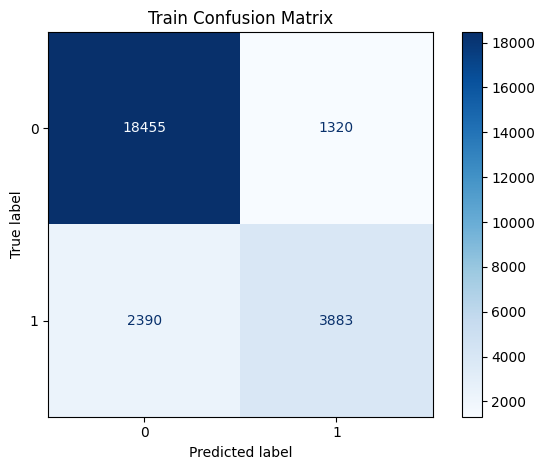

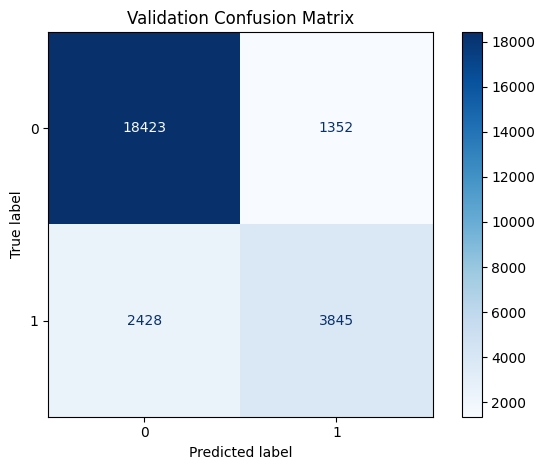

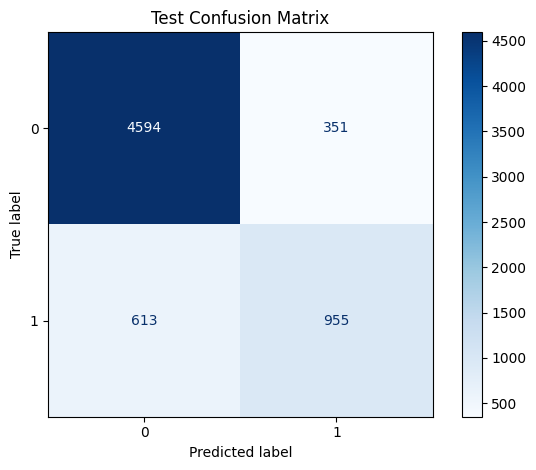

In [6]:
#Logistic Regression

X = df.drop('income', axis=1)
y = (df['income'] == '>50K').astype(int)

num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object','category']).columns

ohe    = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat  = ohe.fit_transform(X[cat_cols])
scaler = StandardScaler()
X_num  = scaler.fit_transform(X[num_cols])

X_all = np.hstack([X_num, X_cat])

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

param_grid = {
    'C':       [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver':  ['lbfgs']
}
grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid, cv=5, scoring='accuracy', n_jobs=-1
)
grid.fit(X_train, y_train)
best_clf = grid.best_estimator_

train_acc = accuracy_score(y_train, best_clf.predict(X_train))
test_acc  = accuracy_score(y_test,  best_clf.predict(X_test))
val_acc   = cross_val_score(
    best_clf, X_train, y_train, cv=5,
    scoring='accuracy', n_jobs=-1
).mean()

print(f"Training accuracy:   {train_acc:.3f}")
print(f"Validation accuracy: {val_acc:.3f}")
print(f"Test accuracy:       {test_acc:.3f}")

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2,
    random_state=42, stratify=y_train
)

clf = SGDClassifier(
    loss='log_loss',
    learning_rate='constant',
    eta0=0.01,
    max_iter=1,
    tol=None,
    warm_start=True,
    random_state=0
)

epochs = 30
train_losses, val_losses = [], []

for ep in range(epochs):
    clf.fit(X_tr, y_tr)
    p_tr  = clf.predict_proba(X_tr)
    p_val = clf.predict_proba(X_val)
    train_losses.append(log_loss(y_tr,   p_tr))
    val_losses.append(  log_loss(y_val, p_val))

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Log-Loss")
plt.title("Learning Curve")
plt.legend()
plt.tight_layout()
plt.show()

def plot_cm(y_true, y_pred, title):
    cm   = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=best_clf.classes_)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_cm(y_train, best_clf.predict(X_train), 'Train Confusion Matrix')

y_val_pred = cross_val_predict(best_clf, X_train, y_train, cv=5, n_jobs=-1)
plot_cm(y_train, y_val_pred, 'Validation Confusion Matrix')

plot_cm(y_test, best_clf.predict(X_test), 'Test Confusion Matrix')

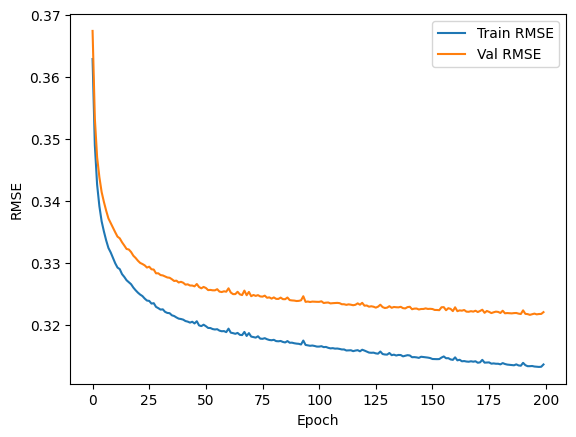

Train Accuracy: 0.8603


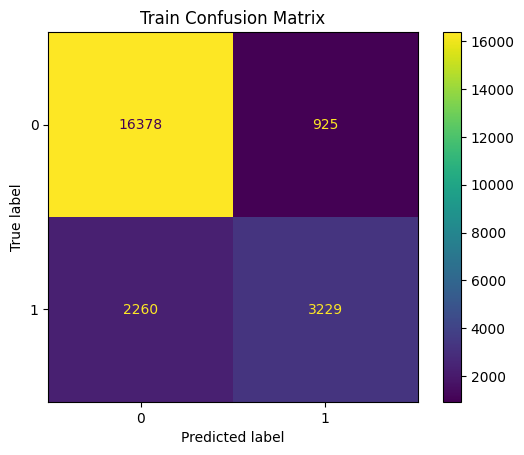

Test Accuracy: 0.8547


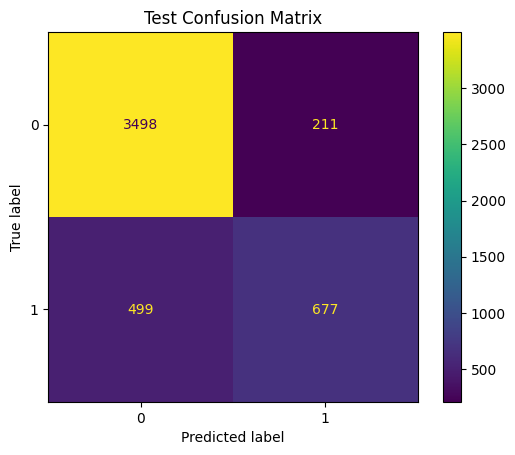

Validation Accuracy: 0.8481


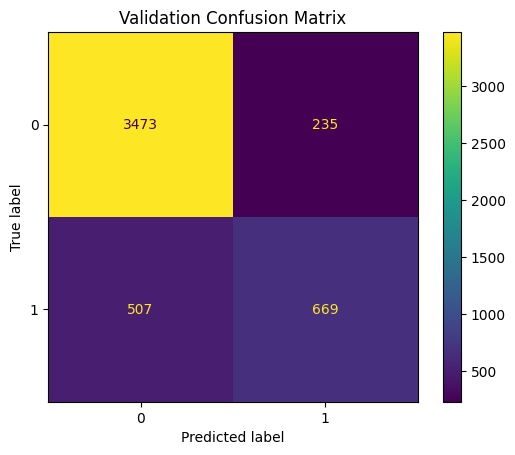

In [7]:
#Neural Network

df['income_bin'] = (df['income'].str.strip() == '>50K').astype(int)

numeric_cols = [
    'age', 'fnlwgt', 'education.num',
    'capital.gain', 'capital.loss',
    'hours.per.week', 'capital_gain_loss_ratio'
]
categorical_cols = [
    'workclass', 'education', 'marital.status',
    'occupation', 'relationship', 'race',
    'sex', 'native.country', 'age_group'
]

def get_adult_data(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X = df[numeric_cols + categorical_cols]
    y = df['income_bin'].values.reshape(-1,1)

    X_trn, X_temp, y_trn, y_temp = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y
    )
    X_vld, X_tst, y_vld, y_tst = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
    )

    ohe    = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    scaler = StandardScaler()

    X_trn_cat = ohe.fit_transform(X_trn[categorical_cols])
    X_vld_cat = ohe.transform(X_vld[categorical_cols])
    X_tst_cat = ohe.transform(X_tst[categorical_cols])

    X_trn_num = scaler.fit_transform(X_trn[numeric_cols])
    X_vld_num = scaler.transform(X_vld[numeric_cols])
    X_tst_num = scaler.transform(X_tst[numeric_cols])

    X_trn_proc = np.hstack([X_trn_num, X_trn_cat])
    X_vld_proc = np.hstack([X_vld_num, X_vld_cat])
    X_tst_proc = np.hstack([X_tst_num, X_tst_cat])

    return X_trn_proc, y_trn, X_vld_proc, y_vld, X_tst_proc, y_tst

X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_adult_data(df)

class Tanh:
    @staticmethod
    def activation(z: np.ndarray) -> np.ndarray:
        return np.tanh(z)

    @staticmethod
    def derivative(z: np.ndarray) -> np.ndarray:
        t = np.tanh(z)
        return 1.0 - t**2

class Linear:
    @staticmethod
    def activation(z: np.ndarray) -> np.ndarray:
        return z

    @staticmethod
    def derivative(z: np.ndarray) -> np.ndarray:
        return np.ones_like(z)

def forward(
    X: np.ndarray,
    W1: np.ndarray, b1: np.ndarray,
    W2: np.ndarray, b2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    Z1 = X.dot(W1) + b1
    A1 = Tanh.activation(Z1)
    Z2 = A1.dot(W2) + b2
    A2 = Linear.activation(Z2)
    return Z1, A1, Z2, A2

def output_layer_grads(
    y: np.ndarray, A1: np.ndarray, Z2: np.ndarray, A2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    m = y.shape[0]
    dZ2 = (A2 - y) * Linear.derivative(Z2)
    dW2 = A1.T.dot(dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    return dW2, db2

def hidden_layer_grads(
    X: np.ndarray, Z1: np.ndarray, A1: np.ndarray,
    W2: np.ndarray, Z2: np.ndarray, A2: np.ndarray, y: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    m = y.shape[0]
    dZ2 = (A2 - y) * Linear.derivative(Z2)
    dA1 = dZ2.dot(W2.T)
    dZ1 = dA1 * Tanh.derivative(Z1)
    dW1 = X.T.dot(dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    return dW1, db1

def init_weights(m_input_features, hidden_neurons, output_neurons):
    rng = np.random.RandomState(0)
    W1 = rng.randn(m_input_features, hidden_neurons) * np.sqrt(2.0/m_input_features)
    b1 = np.zeros((1, hidden_neurons))
    W2 = rng.randn(hidden_neurons, output_neurons) * np.sqrt(2.0/hidden_neurons)
    b2 = np.zeros((1, output_neurons))
    return W1, b1, W2, b2

def get_batches(data_len: int, batch_size: int):
    idx = np.arange(data_len)
    np.random.shuffle(idx)
    return np.array_split(idx, np.ceil(data_len/batch_size).astype(int))

def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.sqrt(np.mean((y_pred - y_true)**2))

class NeuralNetwork:
    def __init__(self, hidden_neurons, output_neurons, alpha, batch_size, epochs, seed):
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.alpha = alpha
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.trn_error = []
        self.vld_error = []

    def fit(self, X, y, X_vld=None, y_vld=None):
        np.random.seed(self.seed)
        m, n_features = X.shape
        self.W1, self.b1, self.W2, self.b2 = init_weights(
            m_input_features=n_features,
            hidden_neurons=self.hidden_neurons,
            output_neurons=self.output_neurons
        )

        for _ in range(self.epochs):
            for batch_idx in get_batches(m, self.batch_size):
                Xb, yb = X[batch_idx], y[batch_idx]
                Z1, A1, Z2, A2 = forward(Xb, self.W1, self.b1, self.W2, self.b2)

                dW2, db2 = output_layer_grads(yb, A1, Z2, A2)
                dW1, db1 = hidden_layer_grads(Xb, Z1, A1, self.W2, Z2, A2, yb)

                self.W2 -= self.alpha * dW2
                self.b2 -= self.alpha * db2
                self.W1 -= self.alpha * dW1
                self.b1 -= self.alpha * db1

            self.trn_error.append(rmse(y, self.predict(X)))
            if X_vld is not None:
                self.vld_error.append(rmse(y_vld, self.predict(X_vld)))
        return self

    def predict(self, X):
        return forward(X, self.W1, self.b1, self.W2, self.b2)[-1]

nn = NeuralNetwork(hidden_neurons=50, output_neurons=1,
                   alpha=0.01, batch_size=64, epochs=200, seed=42)
nn.fit(X_trn, y_trn, X_vld=X_vld, y_vld=y_vld)

plt.plot(nn.trn_error, label='Train RMSE')
plt.plot(nn.vld_error, label='Val RMSE')
plt.xlabel('Epoch'); plt.ylabel('RMSE'); plt.legend(); plt.show()



y_cont_trn = nn.predict(X_trn)
y_pred_trn = (y_cont_trn > 0.5).astype(int)
print(f"Train Accuracy: {accuracy_score(y_trn, y_pred_trn):.4f}")
cm_trn = confusion_matrix(y_trn, y_pred_trn)
ConfusionMatrixDisplay(cm_trn, display_labels=[0,1]).plot()
plt.title("Train Confusion Matrix")
plt.show()

y_cont_tst = nn.predict(X_tst)
y_pred_tst = (y_cont_tst > 0.5).astype(int)
print(f"Test Accuracy: {accuracy_score(y_tst, y_pred_tst):.4f}")
cm_tst = confusion_matrix(y_tst, y_pred_tst)
ConfusionMatrixDisplay(cm_tst, display_labels=[0,1]).plot()
plt.title("Test Confusion Matrix")
plt.show()

y_cont_vld = nn.predict(X_vld)
y_pred_vld = (y_cont_vld > 0.5).astype(int)
print(f"Validation Accuracy: {accuracy_score(y_vld, y_pred_vld):.4f}")
cm_vld = confusion_matrix(y_vld, y_pred_vld)
ConfusionMatrixDisplay(cm_vld, display_labels=[0,1]).plot()
plt.title("Validation Confusion Matrix")
plt.show()